In [132]:
%matplotlib notebook
import tempfile
import numpy as np
from scipy.io import wavfile
from scipy.signal import stft, istft
from scipy.interpolate import griddata, make_interp_spline, interp1d
from matplotlib import pyplot as plt
from ipywidgets import HTML
from IPython.display import display

In [142]:
def display_audio_file(filename):

    widget = HTML(f'''
    <audio controls loop>
      <source src="{filename}" type="audio/wav">
    </audio>
    ''')
    display(widget)

def swing_warp(beats, offset):
    downbeats = np.linspace(0, 1, beats + 1)
    dt = downbeats[1]
    offbeats = offset * dt +  downbeats
    beats = np.concatenate(
        (downbeats,
        offbeats)
    )
    beats.sort()
    return beats[:-1]

def warp_time_domain(warp, wave, k=3):
    ts = np.linspace(0, (wave.shape[0]-1)/sample_rate, wave.shape[0])
    t_min = np.min(ts)
    t_max = np.max(ts)
    
    warp = np.array(warp)
    N = len(warp)
    delta_t = (t_max - t_min) / (N - 1)
    t_inits = np.arange(0, N) * delta_t
    t_warped = warp * (N - 1) * delta_t
    
    t_inits_fit = np.concatenate(((t_inits - t_max)[:-1], t_inits, (t_inits + t_max)[1:]))
    t_warped_fit = np.concatenate(((t_warped - t_max)[:-1], t_warped, (t_warped + t_max)[1:]))
    
    spline = make_interp_spline(t_warped_fit, t_inits_fit, k=k)
    speed_ups = spline.derivative()(ts)
    ts_warped = spline(ts)
    
    fig = plt.figure()
    ax = fig.add_subplot(211)
    ax.plot(ts, ts_warped)
    ax = fig.add_subplot(212)
    ax.plot(ts, speed_ups)
    plt.title('Relative Speed')
    
    input_waveform_interpolator = interp1d(ts, wave, fill_value='extrapolate')
    warped_waveform = input_waveform_interpolator(ts_warped)
    return warped_waveform



def plot_warp(image, warp, k=2):
    
    y_dim, x_dim = image.shape
    xs = np.linspace(0, (image.shape[1] - 1), image.shape[1])
    ys = np.linspace(0, image.shape[0] - 1, image.shape[0])
    
    x_min = np.min(xs)
    x_max = np.max(xs)
    
    warp = np.array(warp)
    N = len(warp)
    delta_x = (x_max - x_min) / (N - 1)
    x_inits = np.arange(0, N) * delta_x
    x_warped = warp * (N - 1) * delta_x
    
    x_inits_fit = np.concatenate(((x_inits - x_max)[:-1], x_inits, (x_inits + x_max)[1:]))
    x_warped_fit = np.concatenate(((x_warped - x_max)[:-1], x_warped, (x_warped + x_max)[1:]))
    
    spline = make_interp_spline(x_warped_fit, x_inits_fit, k=k)
    xs_warped = spline(xs)
    speed_ups = spline.derivative()(xs)
    
    fig = plt.figure()
    ax = fig.add_subplot(211)
    ax.plot(xs, xs_warped)
    ax = fig.add_subplot(212)
    ax.plot(xs, speed_ups)
    plt.title('Relative Speed')

    
def warp_freq_domain(image, warp=np.array([0, 0.9, 2.1, 3]), k=2):
    
    y_dim, x_dim = image.shape
    xs = np.linspace(0, (image.shape[1] - 1), image.shape[1])
    ys = np.linspace(0, image.shape[0] - 1, image.shape[0])
    
    x_min = np.min(xs)
    x_max = np.max(xs)
    
    warp = np.array(warp)
    N = len(warp)
    delta_x = (x_max - x_min) / (N - 1)
    x_inits = np.arange(0, N) * delta_x
    x_warped = warp * (N - 1) * delta_x
    
    x_inits_fit = np.concatenate(((x_inits - x_max)[:-1], x_inits, (x_inits + x_max)[1:]))
    x_warped_fit = np.concatenate(((x_warped - x_max)[:-1], x_warped, (x_warped + x_max)[1:]))
    
    spline = make_interp_spline(x_warped_fit, x_inits_fit, k=k)
    
    xs_warped = spline(xs)
    xs_warped = spline(xs)
    speed_ups = spline.derivative()(xs)
    
    fig = plt.figure()
    ax = fig.add_subplot(211)
    ax.plot(xs, xs_warped)
    ax = fig.add_subplot(212)
    ax.plot(xs, speed_ups)
    plt.title('Relative Speed')
    
    xs_warped = np.mod(xs_warped, x_dim-1)
    
    xs_warped_grid, ys_grid = np.meshgrid(xs_warped, ys)
    xs_grid, ys_grid = np.meshgrid(xs, ys)
    
    points = np.array([xs_grid.ravel(), ys_grid.ravel()]).T
    points_to_interp = np.array([xs_warped_grid.ravel(), ys_grid.ravel()]).T

    interp_data = griddata(points, image.ravel(), points_to_interp)
    return interp_data.reshape(y_dim, x_dim)




def warp_freq_domain_y(image, warp=np.array([0, 0.9, 2.1, 3]), k=2):
    
    y_dim, x_dim = image.shape
    xs = np.linspace(0, (image.shape[1] - 1), image.shape[1])
    ys = np.linspace(0, image.shape[0] - 1, image.shape[0])
    
    y_min = np.min(ys)
    y_max = np.max(ys)
    
    warp = np.array(warp)
    N = len(warp)
    delta_y = (y_max - y_min) / (N - 1)
    y_inits = np.arange(0, N) * delta_y
    y_warped = warp * (N - 1) * delta_y
    
    y_inits_fit = np.concatenate(((y_inits - y_max)[:-1], y_inits, (y_inits + y_max)[1:]))
    y_warped_fit = np.concatenate(((y_warped - y_max)[:-1], y_warped, (y_warped + y_max)[1:]))
    
    spline = make_interp_spline(y_warped_fit, y_inits_fit, k=k)
    
    ys_warped = spline(ys)
    speed_ups = spline.derivative()(ys)
    
    fig = plt.figure()
    ax = fig.add_subplot(211)
    ax.plot(ys, ys_warped)
    ax = fig.add_subplot(212)
    ax.plot(ys, speed_ups)
    plt.title('Relative Speed')
    
    ys_warped = np.mod(ys_warped, y_dim-1)
    
    xs_grid, ys_warped_grid = np.meshgrid(xs, ys_warped)
    xs_grid, ys_grid = np.meshgrid(xs, ys)
    
    points = np.array([xs_grid.ravel(), ys_grid.ravel()]).T
    points_to_interp = np.array([xs_grid.ravel(), ys_warped_grid.ravel()]).T

    interp_data = griddata(points, image.ravel(), points_to_interp)
    return interp_data.reshape(y_dim, x_dim)

In [151]:
# warp is on mapping of output time to input time. It must go from 0, 1. Input time is linear, output time is whatever you specify
# ref_times = [0, 0.25, 0.5, 0.75, 1]
warp = [0, 0.26, 0.55, 0.77, 1]

#warp = tuple_warp(beats=16, offset=0.6)

In [152]:
# let's load up a sample
sample = 'sally_anne_morgan_sample.wav'
sample_rate, waves = wavfile.read(sample)
waves = waves[:, 0] # just 
waves = waves / np.max(np.abs(waves))
display_audio_file(sample)

HTML(value='\n    <audio controls loop>\n      <source src="sally_anne_morgan_sample.wav" type="audio/wav">\n …

<IPython.core.display.Javascript object>


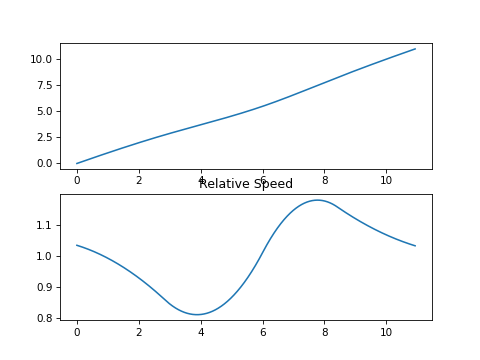

HTML(value='\n    <audio controls loop>\n      <source src="time_domain_transformed.wav" type="audio/wav">\n  …

In [153]:
# first we'll acheive the time warp by speeding up and slowing down the sample as a function of time
# this alters the pitch of the sample because it alters the the frequency of the sound waves being produced

ts = np.linspace(0, (waves.shape[0]-1)/sample_rate, waves.shape[0])
warped_waveform = warp_time_domain(warp, waves, k=3)

filename = tempfile.mktemp('.wav', dir='.')
wavfile.write(filename=filename, rate=sample_rate, data=np.array(255 * 0.5 * (warped_waveform + 1)).astype(np.uint8))
display_audio_file(filename)

<IPython.core.display.Javascript object>


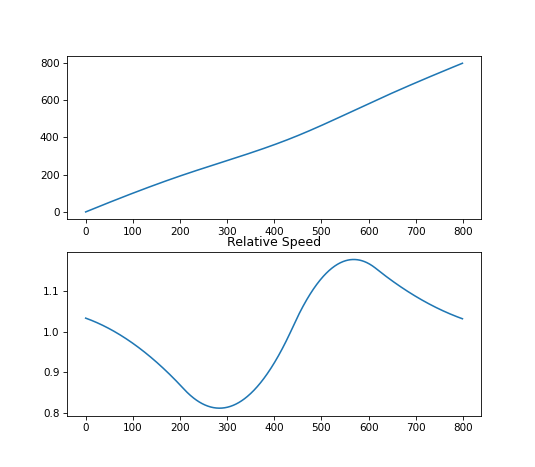

<IPython.core.display.Javascript object>


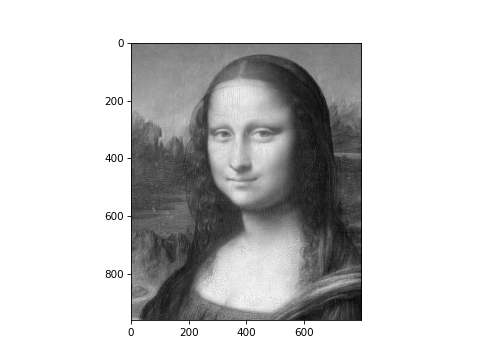

<IPython.core.display.Javascript object>


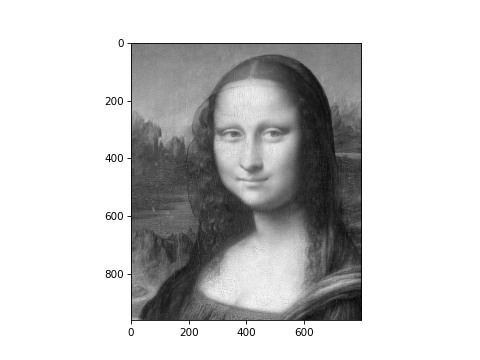

In [154]:
# what we'll do next transform the input waveform using the short-time fourier transform. This produced a 2d
# map of amplitude and phase of different frequencies as a function of time (like a spectrogram, but with phase)
# to get a sense of the warping we're doing, let's apply it in to a recognizable image

image = plt.imread("mona_lisa.jpg")[:, :, 0]
warped_image = warp_freq_domain(image, warp, k=3)
plt.figure()
plt.imshow(image, cmap='gray')

plt.figure()
plt.imshow(warped_image, cmap='gray')

<IPython.core.display.Javascript object>


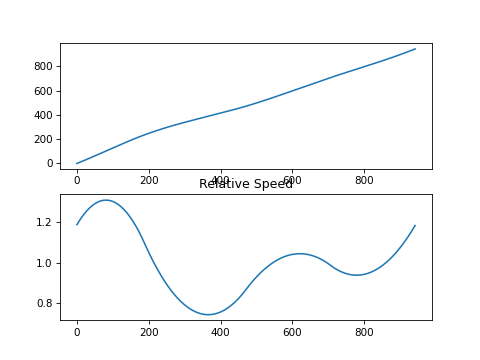

<IPython.core.display.Javascript object>


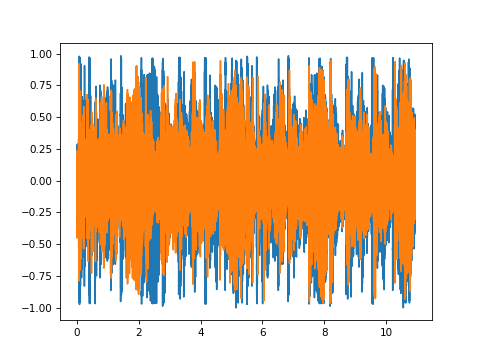

HTML(value='\n    <audio controls loop>\n      <source src="stft_transformed.wav" type="audio/wav">\n    </aud…

In [150]:
stft_fs, stft_ts, zs = stft(waves, fs=sample_rate, nperseg=1024)
warped_zs = warp_freq_domain(zs,  warp, k=3)
recovered_ts, recovered_signal = istft(warped_zs, fs=sample_rate, nperseg=1024)
plt.figure()

plt.plot(ts, waves)
plt.plot(recovered_ts, recovered_signal)

filename = tempfile.mktemp('.wav', dir='.')
wavfile.write(filename=filename, rate=sample_rate, data=np.array(255 * 0.5 * (recovered_signal + 1)).astype(np.uint8))
display_audio_file(filename)

<IPython.core.display.Javascript object>


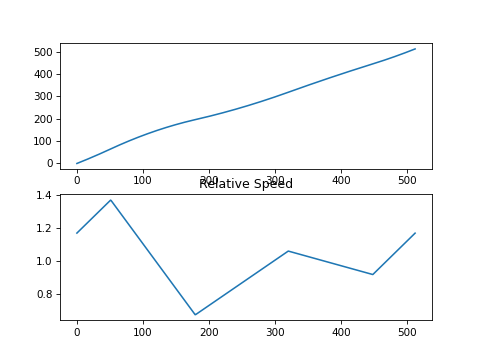

<IPython.core.display.Javascript object>


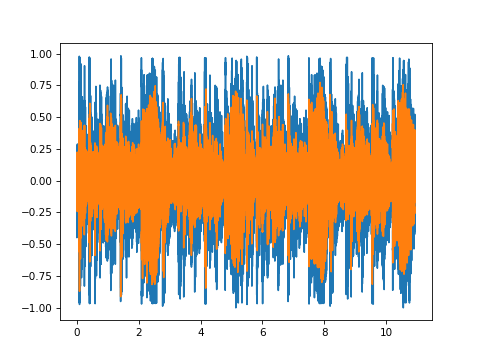

HTML(value='\n    <audio controls loop>\n      <source src="stfat_transformed.wav" type="audio/wav">\n    </au…

In [149]:
warp = [0, .2, 0.5, 0.75, 1]
stft_fs, stft_ts, zs = stft(waves, fs=sample_rate, nperseg=1024)
warped_zs = warp_freq_domain_y(zs,  warp, k=2)
recovered_ts, recovered_signal = istft(warped_zs, fs=sample_rate, nperseg=1024)
plt.figure()

plt.plot(ts, waves)
plt.plot(recovered_ts, recovered_signal)

filename = tempfile.mktemp('.wav', dir='.')
wavfile.write(filename=filename, rate=sample_rate, data=np.array(255 * 0.5 * (recovered_signal + 1)).astype(np.uint8))
display_audio_file(filename)